<a href="https://colab.research.google.com/github/delhian/cv_course/blob/main/Home%20Tasks/flower_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from typing import Tuple
import numpy as np
from torch.utils.data import Dataset, Subset
import torch
from torchvision.datasets import ImageFolder, DatasetFolder
from torchvision import transforms
from torchvision.transforms import Compose, ToTensor, Resize
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn

from torchvision import models
from tqdm.notebook import tqdm


from sklearn.metrics import f1_score
from torch.optim.lr_scheduler import ExponentialLR
from PIL import Image

In [2]:
torch.cuda.is_available()

False

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = '/content/drive/MyDrive/flowerdata-module5.zip'
!unzip -qqo {path} -d ./

In [119]:
# split train/validation with stratify

In [5]:
path = '/content/train/train/'

files = []
for (dirpath, _, filenames) in os.walk(path):
  for f in filenames:
    if f.endswith('.jpg'):
      label = int(dirpath.split('/')[-1])
      files.append([dirpath+'/'+f, label, f,])
files = pd.DataFrame(files, columns = ['path','label','filename',])

files[['label']].value_counts()

label
51       206
77       205
46       157
89       153
73       147
        ... 
35        33
26        33
33        31
34        28
1         27
Length: 102, dtype: int64

In [9]:
train_files, val_files = train_test_split(files, test_size=0.25, stratify= files.label, random_state=13)

In [10]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])


train_transforms = transforms.Compose([\
                                              transforms.RandomRotation(45),
                                              transforms.RandomResizedCrop(224),
                                              transforms.RandomHorizontalFlip(),
                                              transforms.RandomVerticalFlip(),
                                              transforms.ToTensor()
                                       ])
val_transforms = transforms.Compose([
                                              transforms.Resize(256),
                                              transforms.CenterCrop(224),
                                              transforms.ToTensor()
                                     ])

In [201]:
class CustomDataset(Dataset):
    def __init__(self, files, transform, normalize = None):
        files = files.reset_index(drop = True)
        self.paths = files['path'].to_dict()
        self.labels = files['label'].to_dict()
        self.filenames = files['filename'].to_dict()
        self.transform = transform
        self.normalize = normalize
    def __len__(self):
        return len(self.paths)

    def pil_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

    def __getitem__(self, idx):
        path = self.paths[idx]
        # print(path)
        label = self.labels[idx]
        label = torch.LongTensor([label]).squeeze() 
        file_name = self.filenames[idx]
        image = self.pil_loader(path)
        image = self.transform(image)
        if self.normalize:
            image = self.normalize(image)
        return image, file_name, label

In [202]:
train_dataset = CustomDataset(files = train_files, transform=train_transforms, )
val_dataset = CustomDataset(files = val_files, transform=val_transforms)

In [203]:
batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=os.cpu_count())
val_dataloader = DataLoader(val_dataset, batch_size, shuffle=True, num_workers=os.cpu_count())

train_dataloader:


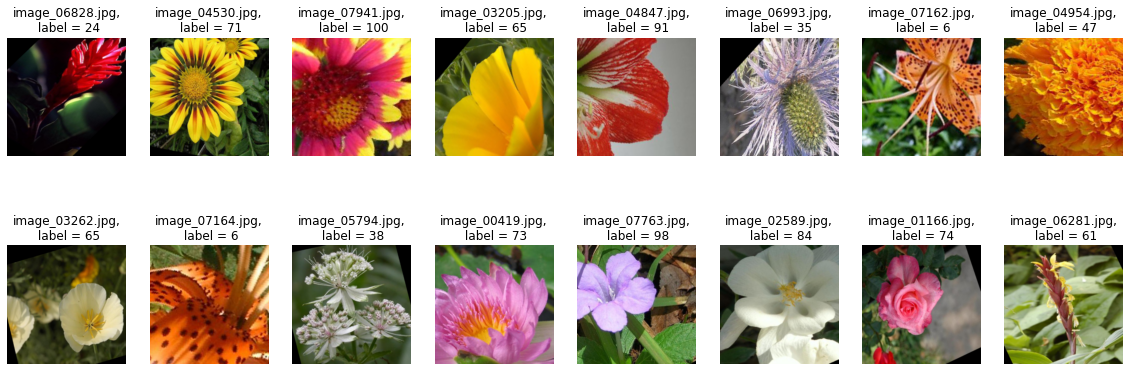

val_dataloader:


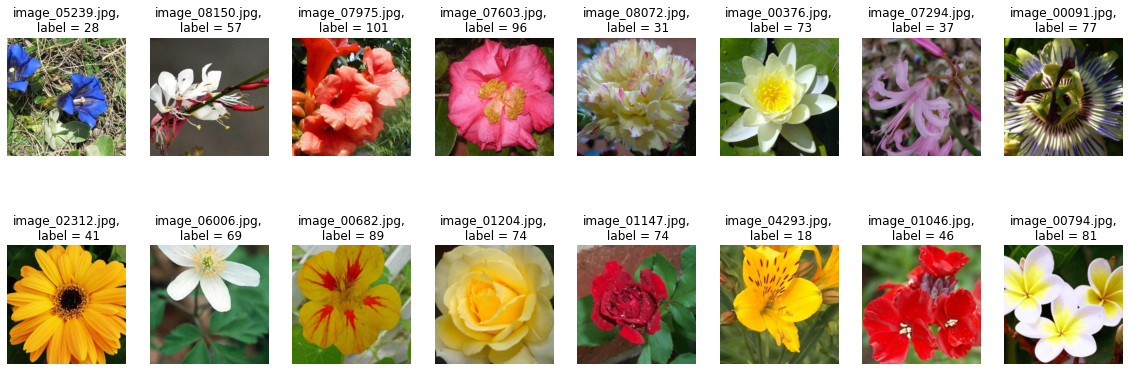

In [205]:
def plot_examples(image, file_name, label):
  figure = plt.figure(figsize=(20, 7))
  cols, rows = 8, 2
  for i in range(0, cols * rows):

    figure.add_subplot(rows, cols, i+1)

    plt.title(f'{file_name[i]},\n label = {label[i].item()}')
    plt.axis("off")
    plt.imshow(image[i].numpy().transpose([1,2,0]))
  plt.show()

print('train_dataloader:')
image, file_name, label = next(iter(train_dataloader))
plot_examples(image, file_name, label)
print('val_dataloader:')
image, file_name, label = next(iter(val_dataloader))
plot_examples(image, file_name, label)

In [206]:
batch_size = 16
train_dataset = CustomDataset(files = train_files, transform=train_transforms, normalize = normalize)
val_dataset = CustomDataset(files = val_files, transform=val_transforms, normalize = normalize)
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size, shuffle=True, num_workers=2)

In [207]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [209]:
# net = models.efficientnet_b1(pretrained=True)
net = models.resnet34(pretrained=True)
net.fc = torch.nn.Linear(in_features=512, out_features=102, bias=True)

for parameter in net.parameters():
    parameter.requres_grad = True

for module in [net.conv1, net.bn1, net.layer1, net.layer2]:
    for parameter in module.parameters():
        parameter.requres_grad = False

net= net.to(device)

In [210]:
checkpoint_path = '/content/drive/MyDrive/checkpoint.pth'

def save_checkpoint(model, optimizer, checkpoint_path, epoch):

    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch
    }, checkpoint_path)

def load_checkpoint(model, checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    return model, optimizer, epoch

In [212]:
def train_model(net,
                optimizer,
                criterion,
                train_dataloader,
                val_dataloader,
                num_epochs):
  
    # check checkpoint
    try:
      net, optimizer, start_epoch = load_checkpoint(net, checkpoint_path)
    except:
      start_epoch = 0
  
    loss_train, loss_valid = [], []
    f1_train, f1_valid = [], []

    scheduler = ExponentialLR(optimizer, gamma=0.95)

    for epoch in range(start_epoch + 1, num_epochs):
        print(f'epoch: {epoch} of {num_epochs}')
        print(f'LR: {scheduler.get_last_lr()[0]}')
        torch.set_grad_enabled(True)
        net.train()
        losses, f1 = [], []
        print('TRAIN:', end =' ')
        for i, (image, _, label) in enumerate(tqdm(train_dataloader)):
            # print(i, end =', ')
            image = image.to(device)
            label = label.to(device)
            output = net(image)
            loss = criterion(output, label)
            losses.append(loss.item())
            f1.append(f1_score(label.cpu().numpy(), output.argmax(1).cpu().numpy(), average='macro'))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        mean_losses, mean_f1 = np.mean(losses),  np.mean(f1)
        print(f'mean_losses: {mean_losses}, mean_f1: {mean_f1}')
        loss_train.append(mean_losses)
        f1_train.append(mean_f1)
        torch.set_grad_enabled(False)
        net.eval()
        losses, f1 = [], []
        print('VALIDATION:', end =' ')
        for i, (image, _, label) in enumerate(tqdm(val_dataloader)):
            # print(i, end =', ')
            image = image.to(device)
            label = label.to(device)
            output = net(image)
            loss = criterion(output, label)
            losses.append(loss.item())
            f1.append(f1_score(label.cpu().numpy(), net(image).argmax(1).cpu().numpy(), average='macro'))
        mean_losses, mean_f1 = np.mean(losses),  np.mean(f1)
        print(f'mean_losses: {mean_losses}, mean_f1: {mean_f1}')

        loss_valid.append(mean_losses)
        f1_valid.append(mean_f1)
        scheduler.step()
        save_checkpoint(net, optimizer, checkpoint_path, epoch)

    return loss_train, f1_train, loss_valid, f1_valid

In [213]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

In [214]:
loss_train, f1_train, loss_valid, f1_valid = train_model(net = net,
                                                             optimizer = optimizer,
                                                             criterion = criterion,
                                                             train_dataloader = train_dataloader,
                                                             val_dataloader = val_dataloader,
                                                             num_epochs = 10)

epoch: 1 of 10
LR: 0.01
TRAIN: 

  0%|          | 0/308 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [161]:
net(image).dtype

torch.float32

In [163]:
label

tensor([[29],
        [35],
        [90],
        [77],
        [86],
        [69],
        [51],
        [76],
        [51],
        [17],
        [77],
        [54],
        [94],
        [94],
        [94],
        [69]])

In [181]:
label = label.squeeze()

# label = label.type(torch.LongTensor)

In [182]:
criterion(net(image), label)

tensor(5.0922, grad_fn=<NllLossBackward0>)

NameError: ignored

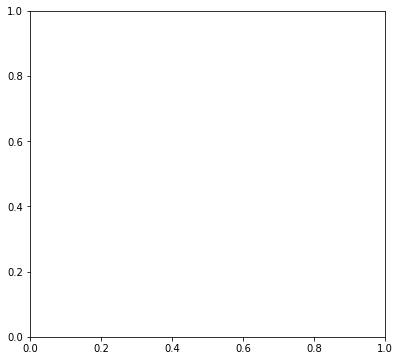

In [166]:
plt.figure(figsize=(14, 6))

plt.subplot(121)
plt.plot(range(1, len(loss_train) + 1), loss_train, color="b")
plt.plot(range(1, len(loss_train) + 1), loss_valid, color="r")
plt.xlabel("epochs")
plt.title("loss")

plt.subplot(122)
plt.plot(range(1, len(loss_train) + 1), f1_train, color="b")
plt.plot(range(1, len(loss_train) + 1), f1_valid, color="r")
plt.xlabel("epochs")
plt.title("mean_f1")

plt.show()

In [25]:
from PIL import Image

class TestDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.files = []
        for (dirpath, _, filenames) in os.walk(self.path):
            for f in filenames:
                if f.endswith('.jpg'):
                    p = {}
                    p['img_path'] = dirpath + '/' + f
                    self.files.append(p)
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def pil_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

    def __getitem__(self, idx):
        img_path = self.files[idx]['img_path']
        file_name = img_path.split('/')[-1]
        image = self.pil_loader(img_path)
        if self.transform:
            image = self.transform(image)
        return image, file_name

In [97]:
test_transforms = transforms.Compose([
                                              transforms.Resize((299, 299)),
                                              transforms.ToTensor(),
                                              transforms.Normalize([0.485, 0.456, 0.406],
                                                                 [0.229, 0.224, 0.225])
                                     ])

test_transforms_without_Normalize  = transforms.Compose([
                                              transforms.Resize((299, 299)),
                                              transforms.ToTensor(),
                                              # transforms.Normalize([0.485, 0.456, 0.406],
                                              #                    [0.229, 0.224, 0.225])
                                     ])


test_dataset = TestDataset('/content/train/train/1', transform=test_transforms)
test_dataset_without_Normalize = TestDataset('/content/train/train/1', transform=test_transforms_without_Normalize)
# testloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [102]:
test_dataset[0]

(tensor([[[-1.7412, -1.7069, -1.7240,  ..., -1.0390, -1.0390, -1.1075],
          [-1.7412, -1.7412, -1.7754,  ..., -1.0390, -1.0219, -1.1247],
          [-1.7583, -1.7583, -1.7583,  ..., -1.0904, -1.0733, -1.1589],
          ...,
          [-1.2103, -1.1247, -1.0048,  ..., -1.8097, -1.8097, -1.8097],
          [-1.1418, -1.0390, -0.8678,  ..., -1.7754, -1.7583, -1.7412],
          [-0.3541, -0.2856, -0.1828,  ..., -0.7137, -0.6965, -0.6794]],
 
         [[-1.6681, -1.6331, -1.6506,  ..., -0.4601, -0.4426, -0.5126],
          [-1.6681, -1.6681, -1.7031,  ..., -0.4251, -0.4076, -0.4951],
          [-1.6856, -1.6856, -1.6856,  ..., -0.4076, -0.3901, -0.4601],
          ...,
          [-0.6877, -0.5651, -0.3725,  ..., -1.6506, -1.6681, -1.6506],
          [-0.7577, -0.6176, -0.3901,  ..., -1.6856, -1.6681, -1.6506],
          [ 0.0476,  0.1527,  0.3102,  ..., -0.6001, -0.5826, -0.5651]],
 
         [[-1.4733, -1.4384, -1.4559,  ..., -1.1770, -1.2119, -1.3164],
          [-1.4733, -1.4733,

In [99]:
next(iter(test_dataset))

(tensor([[[-1.7412, -1.7069, -1.7240,  ..., -1.0390, -1.0390, -1.1075],
          [-1.7412, -1.7412, -1.7754,  ..., -1.0390, -1.0219, -1.1247],
          [-1.7583, -1.7583, -1.7583,  ..., -1.0904, -1.0733, -1.1589],
          ...,
          [-1.2103, -1.1247, -1.0048,  ..., -1.8097, -1.8097, -1.8097],
          [-1.1418, -1.0390, -0.8678,  ..., -1.7754, -1.7583, -1.7412],
          [-0.3541, -0.2856, -0.1828,  ..., -0.7137, -0.6965, -0.6794]],
 
         [[-1.6681, -1.6331, -1.6506,  ..., -0.4601, -0.4426, -0.5126],
          [-1.6681, -1.6681, -1.7031,  ..., -0.4251, -0.4076, -0.4951],
          [-1.6856, -1.6856, -1.6856,  ..., -0.4076, -0.3901, -0.4601],
          ...,
          [-0.6877, -0.5651, -0.3725,  ..., -1.6506, -1.6681, -1.6506],
          [-0.7577, -0.6176, -0.3901,  ..., -1.6856, -1.6681, -1.6506],
          [ 0.0476,  0.1527,  0.3102,  ..., -0.6001, -0.5826, -0.5651]],
 
         [[-1.4733, -1.4384, -1.4559,  ..., -1.1770, -1.2119, -1.3164],
          [-1.4733, -1.4733,

In [85]:
filelist['filename'][7]

'image_06742.jpg'

In [93]:
next(iter(train_dataset))

(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.2275, 0.2275, 0.2235],
          [0.0000, 0.0000, 0.0000,  ..., 0.2196, 0.2314, 0.2314],
          [0.0000, 0.0000, 0.0000,  ..., 0.2275, 0.2314, 0.2314],
          ...,
          [0.1294, 0.1294, 0.1333,  ..., 0.1569, 0.1529, 0.1529],
          [0.1255, 0.1255, 0.1294,  ..., 0.1490, 0.1490, 0.1490],
          [0.1255, 0.1216, 0.1294,  ..., 0.1412, 0.1412, 0.1412]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.2471, 0.2471, 0.2431],
          [0.0000, 0.0000, 0.0000,  ..., 0.2431, 0.2431, 0.2431],
          [0.0000, 0.0000, 0.0000,  ..., 0.2471, 0.2431, 0.2431],
          ...,
          [0.1843, 0.1843, 0.1882,  ..., 0.1765, 0.1725, 0.1725],
          [0.1804, 0.1804, 0.1843,  ..., 0.1686, 0.1686, 0.1686],
          [0.1804, 0.1765, 0.1843,  ..., 0.1608, 0.1569, 0.1569]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.2627, 0.2627, 0.2588],
          [0.0000, 0.0000, 0.0000,  ..., 0.2667, 0.2627, 0.2627],
          [0.0000, 0.0000, 0.0000,  ...,

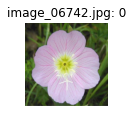

In [80]:
figure = plt.figure(figsize=(25, 7))
cols, rows = 8, 4

for i in range(cols * rows):
    img, _ = test_dataset[i]
    img_w, filename = test_dataset_without_Normalize[i]
    img = img.to(device)
    output = net.forward(img[None, :, :, :])
    tt= output
    output = output.argmax(1).cpu().numpy()
    figure.add_subplot(rows, cols, i+1)

    img_w = img_w.swapaxes(0,1)
    img_w = img_w.swapaxes(1,2)
    plt.title(f'{filename}: {output[0]}')
    plt.axis("off")
    plt.imshow(img_w)

    break

In [ ]:
testloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

In [ ]:
images, filename = next(iter(testloader))
images = images.to(device)
output = net(images)
output = output.argmax(1).cpu().numpy()
Id_Category_map = {x:y for (x ,y) in zip(filename, output)}

In [ ]:
submission = pd.read_csv('sample_submission.csv')

submission['Category'] = submission['Id'].map(Id_Category_map)

In [ ]:
submission.to_csv('submission.csv', index=False)
pd.read_csv('submission.csv')

,Id,Category
0,image_00028.jpg,83
1,image_00059.jpg,77
2,image_00061.jpg,77
3,image_00063.jpg,77
4,image_00071.jpg,77
...,...,...
813,image_08105.jpg,11
814,image_08113.jpg,95
815,image_08145.jpg,55
816,image_08155.jpg,85
